In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import logging
import datetime

In [2]:
def set_df(arr, col_names):
    df = pd.DataFrame(arr)
    df.columns = col_names
    return df

In [3]:
def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
    
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
        
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}    
        
        
        
        
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def predict_chunk(df_, clfs_, meta_, features, train_mean):
     
    agg_ = add_flux_feats(df_)    
        
    # 增加是否在银河系的特征
    meta_.distmod.fillna(0,inplace=True)
    meta_['in_galaxy'] = 0
    meta_.loc[(meta_.distmod == 0), 'in_galaxy'] = 1
    # 增加是否在银河系的特征


    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )
    
    
    # 增加 mean_flux_per_band
    full_test = add_band_feats(full_test, df_)
    # 增加 mean_flux_per_band
    
    # 增加按MJD划分时间统计得到的特征
    full_test = add_feats_within_time_interval(6, 59580.0343, 60674.363, full_test, df_)
    # 增加按MJD划分时间统计得到的特征
    
    
    
    full_test_in_gal = full_test[full_test['in_galaxy']==1]
    objects_in_gal = full_test_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    full_test_out_gal = full_test[full_test['in_galaxy']==0]
    objects_out_gal = full_test_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    
    
    

#     for df in [full_test_in_gal, full_test_out_gal]:
#         del df['object_id']
#         df_mean = df.mean(axis=0)
#         df.fillna(df_mean, inplace=True)

    in_classes = [6, 16, 53, 65, 92]
    out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95] 

    if full_test_in_gal.shape[0] == 0:
        in_df = pd.DataFrame(columns=in_classes)
    
    else :
        del full_test_in_gal['object_id']
        df_mean = full_test_in_gal.mean(axis=0)
        full_test_in_gal.fillna(df_mean, inplace=True)
    
        # Make predictions in galaxy
        preds_in_gal = None
        for clf in clfs_[0]:
            if preds_in_gal is None:
                preds_in_gal = clf.predict_proba(full_test_in_gal[features]) / len(clfs_[0])
            else:
                preds_in_gal += clf.predict_proba(full_test_in_gal[features]) / len(clfs_[0])
        
        in_df = set_df(preds_in_gal, in_classes)
            

    if full_test_out_gal.shape[0] == 0:
        out_df = pd.DataFrame(columns=out_classes)     
    
    else :
        del full_test_out_gal['object_id']
        df_mean = full_test_out_gal.mean(axis=0)
        full_test_out_gal.fillna(df_mean, inplace=True)
                
        # Make predictions out of galaxy
        preds_out_gal = None
        for clf in clfs_[1]:
            if preds_out_gal is None:
                preds_out_gal = clf.predict_proba(full_test_out_gal[features]) / len(clfs_[1])
            else:
                preds_out_gal += clf.predict_proba(full_test_out_gal[features]) / len(clfs_[1])
        
        out_df = set_df(preds_out_gal, out_classes)
        



            
            
    # Merge predictions
   

    
    
    in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)
    
    preds_ = in_out_df.values
    
    
            
            
            
    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
#     preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in classes])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del agg_, full_test, preds_
    gc.collect()

    return preds_df_


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(r'../feat/importances_{}.png'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    importances_.sort_values('mean_gain', ascending=False).to_csv(r'../feat/feat_rank_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    
    print('oof_preds:')
    print(oof_preds)
    
    val_score = multi_weighted_logloss(y_true=y, y_preds=oof_preds)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % val_score)

    return clfs, importances, oof_preds, val_score



def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]




In [4]:
def add_feats_within_time_interval_out(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
#                                                                           'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
#                                                                          'interval_{}_flux_skew'.format(i+1):'skew'
                                                                        })
        print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
#     # interval_#_flux_？ 互相做差
#     for key in ['max', 'min', 'mean']:
# #     for key in ['mean']:
#         key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
#         for col in key_cols:
#             subtract_cols = [col_ for col_ in key_cols if col_ < col]
#             for sub_col in subtract_cols:
#                 df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

In [5]:
def add_feats_within_time_interval(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
                                                                          'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
                                                                         'interval_{}_flux_skew'.format(i+1):'skew'})
        print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
    # interval_#_flux_？ 互相做差
    for key in ['max', 'min', 'mean']:
#     for key in ['max']:
        key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
        for col in key_cols:
            subtract_cols = [col_ for col_ in key_cols if col_ < col]
            for sub_col in subtract_cols:
                df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
                print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

In [6]:
def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df

    
#     print('Adding feats for the flux mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
#     stats['object_id'] = stats.index
#     stats.columns = [str(col) + '_mean' for col in stats.columns.tolist()]
#     df = df.merge(db, on='object_id', how='left').fillna(0)
#     print('Feats added:',stats.columns.tolist())
    
    
    

In [7]:
def add_flux_second_order_features_to_agg(df):
#     df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
#     df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
#     df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

#     del df['mjd_max'], df['mjd_min']

    return df

In [8]:
def agg_by_flux_feats(df):
    
    df['flux_ratio'] = df['flux'] / df['flux_err']
    
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs = {
#         'mjd': ['min', 'max', 'size'],
#         'passband': ['mean', 'std', 'var'],  
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'flux_ratio': ['min', 'max', 'mean', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }   

#     aggs['flux_ratio_sq'] = ['sum']
#     aggs['flux_by_flux_ratio_sq'] = ['sum']

    
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_df.columns = new_columns

    agg_df = add_flux_second_order_features_to_agg(df=agg_df)
    
    return agg_df

In [9]:
def get_by_galaxy(df):
    df_in_gal = df[df['in_galaxy']==1]
    objects_in_gal = df_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    df_out_gal = df[df['in_galaxy']==0]
    objects_out_gal = df_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    print('Total number should be', len(df['object_id'].unique().tolist()))
    return df_in_gal, df_out_gal

In [10]:
def add_photo_feats(df):
    df['hostgal_photoz_ratio'] = df['hostgal_photoz']/df['hostgal_photoz_err']
    
    return df

In [11]:
def fabriquer_feat(db, meta):
    
    # 去除无效特征
    del meta['hostgal_specz']
    print('Feature hostgal_specz is removed')
    
    # META数据提供划分银河系内外的依据
    # 增加是否属于银河系的特征
    meta.distmod.fillna(0,inplace=True)
    meta['in_galaxy'] = 0
    meta.loc[(meta.distmod == 0), 'in_galaxy'] = 1
    
    # 时序数据和META数据融合，形成以mjd为行的数据
    db_meta = db.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for MJD relevant data and META data ', db_meta.shape)
    
    # 对时序融合数据进行分割
    db_in_gal, db_out_gal = get_by_galaxy(db_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', db_in_gal.shape, db_out_gal.shape)
    
    # 基本特征聚合
    agg_df = agg_by_flux_feats(db)
    print('Dimension of aggregated data on flux features', agg_df.shape)
    
    # 聚合数据和META数据融合，形成以object_id为行的数据
    agg_df_meta = agg_df.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for Object relevant data and META data', agg_df_meta.shape)

    # 对object融合数据进行分割
    df_in_gal, df_out_gal = get_by_galaxy(agg_df_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', df_in_gal.shape, df_out_gal.shape)

    
    # 对银河系内外数据分别提取特征
    print('Features extraction begins...')
    
    # 银河系内
    print('In terms of that in the Galaxy...')
    
    # 增加band相关特征
    df_in_gal = add_band_feats(df_in_gal, db_in_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_in_gal = add_feats_within_time_interval(6, df_in_gal, db_in_gal)
    
    # 银河系外
    print('In terms of that out of the Galaxy...')
    
    # 增加hostgal_photoz相关特征
    df_out_gal = add_photo_feats(df_out_gal)
    
    # 增加band相关特征
    df_out_gal = add_band_feats(df_out_gal, db_out_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_out_gal = add_feats_within_time_interval_out(6, df_out_gal, db_out_gal) 
    
    return df_in_gal, df_out_gal
    
    
    
    
    
    

    


Feature hostgal_specz is removed
Dimension of merge data for MJD relevant data and META data  (1421705, 17)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (400574, 17) (1021131, 17)
Dimension of aggregated data on flux features (7848, 18)
Dimension of merge data for Object relevant data and META data (7848, 30)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (2325, 30) (5523, 30)
Features extraction begins...
In terms of that in the Galaxy...
Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mea

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...
Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...
Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max', 'band_1_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_0_flux_max', 'band_3_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_0_flux_max', 'band_4_flux_max_minus_band_1_flux_max', 'band_4_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_0_flux_max', 'band_5_flux_max_minus_band_1_flux_max', 'band_5_flux_max_minus_band_2_flu

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_min', 'band_1_flux_min', 'band_2_flux_min', 'band_3_flux_min', 'band_4_flux_min', 'band_5_flux_min']
Adding feats for the flux (max-min)/mean per band...
Feature added: band_0_flux_diff2
Feature added: band_1_flux_diff2
Feature added: band_2_flux_diff2
Feature added: band_3_flux_diff2
Feature added: band_4_flux_diff2
Feature added: band_5_flux_diff2
Dimension of data after adding features relevant to bands (2325, 102)
Number of Intervals : 6
Min and Max MJD time : 59580.0347, 60674.363
Interval #1, record quantity: 38277


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


New features added:  ['object_id', 'interval_1_flux_mean', 'interval_1_flux_std', 'interval_1_flux_min', 'interval_1_flux_max', 'interval_1_flux_skew']
Interval #2, record quantity: 82096
New features added:  ['object_id', 'interval_2_flux_mean', 'interval_2_flux_std', 'interval_2_flux_min', 'interval_2_flux_max', 'interval_2_flux_skew']
Interval #3, record quantity: 61348
New features added:  ['object_id', 'interval_3_flux_mean', 'interval_3_flux_std', 'interval_3_flux_min', 'interval_3_flux_max', 'interval_3_flux_skew']
Interval #4, record quantity: 73604
New features added:  ['object_id', 'interval_4_flux_mean', 'interval_4_flux_std', 'interval_4_flux_min', 'interval_4_flux_max', 'interval_4_flux_skew']
Interval #5, record quantity: 56390
New features added:  ['object_id', 'interval_5_flux_mean', 'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max', 'interval_5_flux_skew']
Interval #6, record quantity: 88858
New features added:  ['object_id', 'interval_6_flux_mean', '

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...
Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...
Feats ad

[INFO]2018-10-31 10:13:57,015:main:Index(['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
       'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
       'flux_err_median',
       ...
       'interval_4_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_1_flux_mean',
       'interval_5_flux_mean_minus_interval_2_flux_mean',
       'interval_5_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_1_flux_mean',
       'interval_6_flux_mean_minus_interval_2_flux_mean',
       'interval_6_flux_mean_minus_interval_3_flux_mean',
       'interval_6_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_5_flux_mean'],
      dtype='object', length=175)


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.173672	training's wloss: 0.335038	valid_1's multi_logloss: 0.207643	valid_1's wloss: 0.391873
[200]	training's multi_logloss: 0.0565711	training's wloss: 0.13232	valid_1's multi_logloss: 0.104721	valid_1's wloss: 0.226977
[300]	training's multi_logloss: 0.0317678	training's wloss: 0.079609	valid_1's multi_logloss: 0.0845329	valid_1's wloss: 0.191199
[400]	training's multi_logloss: 0.0236034	training's wloss: 0.060313	valid_1's multi_logloss: 0.0780382	valid_1's wloss: 0.179338
[500]	training's multi_logloss: 0.0199029	training's wloss: 0.0516984	valid_1's multi_logloss: 0.0747359	valid_1's wloss: 0.173556
[600]	training's multi_logloss: 0.0177971	training's wloss: 0.0471529	valid_1's multi_logloss: 0.0732516	valid_1's wloss: 0.170517
[700]	training's multi_logloss: 0.0165204	training's wloss: 0.0445266	valid_1's multi_logloss: 0.0724725	valid_1's wloss: 0.168157
[800]	training's multi_loglos

[INFO]2018-10-31 10:14:16,809:main:0.16305875743560727


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.166421	training's wloss: 0.306897	valid_1's multi_logloss: 0.240465	valid_1's wloss: 0.624845
[200]	training's multi_logloss: 0.0509286	training's wloss: 0.117994	valid_1's multi_logloss: 0.144346	valid_1's wloss: 0.531852
[300]	training's multi_logloss: 0.0294712	training's wloss: 0.0751955	valid_1's multi_logloss: 0.131986	valid_1's wloss: 0.507958
[400]	training's multi_logloss: 0.0222766	training's wloss: 0.0594136	valid_1's multi_logloss: 0.129213	valid_1's wloss: 0.493522
[500]	training's multi_logloss: 0.0190328	training's wloss: 0.0519337	valid_1's multi_logloss: 0.126829	valid_1's wloss: 0.486096
[600]	training's multi_logloss: 0.0173708	training's wloss: 0.0482171	valid_1's multi_logloss: 0.125728	valid_1's wloss: 0.48291
[700]	training's multi_logloss: 0.0162031	training's wloss: 0.0456351	valid_1's multi_logloss: 0.125161	valid_1's wloss: 0.480772
[800]	training's multi_logloss: 

[INFO]2018-10-31 10:14:33,996:main:0.47603645845183806


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.172604	training's wloss: 0.332617	valid_1's multi_logloss: 0.230303	valid_1's wloss: 0.504507
[200]	training's multi_logloss: 0.0564987	training's wloss: 0.134999	valid_1's multi_logloss: 0.118401	valid_1's wloss: 0.311887
[300]	training's multi_logloss: 0.0320984	training's wloss: 0.081964	valid_1's multi_logloss: 0.0957751	valid_1's wloss: 0.261769
[400]	training's multi_logloss: 0.0240284	training's wloss: 0.0633075	valid_1's multi_logloss: 0.0875565	valid_1's wloss: 0.24273
[500]	training's multi_logloss: 0.0201349	training's wloss: 0.0544761	valid_1's multi_logloss: 0.0832015	valid_1's wloss: 0.233154
[600]	training's multi_logloss: 0.0179291	training's wloss: 0.0496454	valid_1's multi_logloss: 0.0804486	valid_1's wloss: 0.227282
[700]	training's multi_logloss: 0.0167113	training's wloss: 0.0467895	valid_1's multi_logloss: 0.0791067	valid_1's wloss: 0.223293
[800]	training's multi_loglo

[INFO]2018-10-31 10:14:53,620:main:0.2180753187860529


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.17666	training's wloss: 0.337554	valid_1's multi_logloss: 0.20057	valid_1's wloss: 0.351385
[200]	training's multi_logloss: 0.0584124	training's wloss: 0.135076	valid_1's multi_logloss: 0.0918082	valid_1's wloss: 0.21136
[300]	training's multi_logloss: 0.0337768	training's wloss: 0.0830122	valid_1's multi_logloss: 0.0689419	valid_1's wloss: 0.175248
[400]	training's multi_logloss: 0.0249785	training's wloss: 0.0632995	valid_1's multi_logloss: 0.0609529	valid_1's wloss: 0.158661
[500]	training's multi_logloss: 0.0208887	training's wloss: 0.0546127	valid_1's multi_logloss: 0.0569553	valid_1's wloss: 0.151609
[600]	training's multi_logloss: 0.0186105	training's wloss: 0.0500843	valid_1's multi_logloss: 0.0551471	valid_1's wloss: 0.148356
[700]	training's multi_logloss: 0.0172543	training's wloss: 0.0472525	valid_1's multi_logloss: 0.053648	valid_1's wloss: 0.145555
[800]	training's multi_loglos

[INFO]2018-10-31 10:15:12,675:main:0.14233310053886108


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.171326	training's wloss: 0.31887	valid_1's multi_logloss: 0.237028	valid_1's wloss: 0.505851
[200]	training's multi_logloss: 0.0532518	training's wloss: 0.125566	valid_1's multi_logloss: 0.134345	valid_1's wloss: 0.371265
[300]	training's multi_logloss: 0.0302237	training's wloss: 0.0779025	valid_1's multi_logloss: 0.117438	valid_1's wloss: 0.342138
[400]	training's multi_logloss: 0.0224647	training's wloss: 0.0600425	valid_1's multi_logloss: 0.111615	valid_1's wloss: 0.331857
[500]	training's multi_logloss: 0.0192437	training's wloss: 0.0522187	valid_1's multi_logloss: 0.108859	valid_1's wloss: 0.325092
[600]	training's multi_logloss: 0.0175798	training's wloss: 0.0487879	valid_1's multi_logloss: 0.107042	valid_1's wloss: 0.323289
[700]	training's multi_logloss: 0.0163846	training's wloss: 0.0460371	valid_1's multi_logloss: 0.106007	valid_1's wloss: 0.322046
[800]	training's multi_logloss: 

[INFO]2018-10-31 10:15:31,609:main:0.32048996209116876
[INFO]2018-10-31 10:15:31,619:main:MULTI WEIGHTED LOG LOSS : 0.26365 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


oof_preds:
[[6.92526457e-04 4.71099846e-03 1.09315231e-03 8.48578546e-04
  9.92654744e-01]
 [2.74187130e-04 9.59031516e-05 1.09232342e-04 9.99440611e-01
  8.00659214e-05]
 [2.20638203e-04 5.02932344e-03 2.22048023e-04 9.94405646e-01
  1.22344207e-04]
 ...
 [1.94329272e-02 9.64210728e-01 3.71688728e-03 8.97795989e-03
  3.66149772e-03]
 [8.30744654e-04 1.36950410e-04 2.32700708e-04 9.98436876e-01
  3.62728538e-04]
 [9.76678428e-01 5.97194943e-04 1.88165429e-02 2.21009958e-03
  1.69773474e-03]]


[INFO]2018-10-31 10:15:46,314:main:Index(['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
       'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
       'flux_err_median',
       ...
       'interval_3_flux_max', 'interval_4_flux_mean', 'interval_4_flux_min',
       'interval_4_flux_max', 'interval_5_flux_mean', 'interval_5_flux_min',
       'interval_5_flux_max', 'interval_6_flux_mean', 'interval_6_flux_min',
       'interval_6_flux_max'],
      dtype='object', length=119)


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.917978	training's wloss: 1.145	valid_1's multi_logloss: 1.03292	valid_1's wloss: 1.41057
[200]	training's multi_logloss: 0.721904	training's wloss: 0.909904	valid_1's multi_logloss: 0.905727	valid_1's wloss: 1.30962
[300]	training's multi_logloss: 0.624551	training's wloss: 0.766897	valid_1's multi_logloss: 0.866837	valid_1's wloss: 1.26794
[400]	training's multi_logloss: 0.55224	training's wloss: 0.652477	valid_1's multi_logloss: 0.849694	valid_1's wloss: 1.25187
[500]	training's multi_logloss: 0.494578	training's wloss: 0.565394	valid_1's multi_logloss: 0.839018	valid_1's wloss: 1.24442
[600]	training's multi_logloss: 0.44696	training's wloss: 0.496414	valid_1's multi_logloss: 0.832042	valid_1's wloss: 1.24209
Early stopping, best iteration is:
[592]	training's multi_logloss: 0.450552	training's wloss: 0.50173	valid_1's multi_logloss: 0.83195	valid_1's wloss: 1.24059


[INFO]2018-10-31 10:16:19,296:main:1.24059431063788


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.918249	training's wloss: 1.1509	valid_1's multi_logloss: 1.01286	valid_1's wloss: 1.30815
[200]	training's multi_logloss: 0.718507	training's wloss: 0.905449	valid_1's multi_logloss: 0.881845	valid_1's wloss: 1.20105
[300]	training's multi_logloss: 0.617309	training's wloss: 0.748585	valid_1's multi_logloss: 0.842636	valid_1's wloss: 1.1678
Early stopping, best iteration is:
[328]	training's multi_logloss: 0.595267	training's wloss: 0.713095	valid_1's multi_logloss: 0.835916	valid_1's wloss: 1.16444


[INFO]2018-10-31 10:16:39,586:main:1.1644377820685219


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.910742	training's wloss: 1.15212	valid_1's multi_logloss: 1.03839	valid_1's wloss: 1.32937
[200]	training's multi_logloss: 0.710104	training's wloss: 0.905459	valid_1's multi_logloss: 0.920914	valid_1's wloss: 1.22512
[300]	training's multi_logloss: 0.607241	training's wloss: 0.74356	valid_1's multi_logloss: 0.886274	valid_1's wloss: 1.18534
[400]	training's multi_logloss: 0.535328	training's wloss: 0.627284	valid_1's multi_logloss: 0.871768	valid_1's wloss: 1.17527
Early stopping, best iteration is:
[402]	training's multi_logloss: 0.534012	training's wloss: 0.625239	valid_1's multi_logloss: 0.871501	valid_1's wloss: 1.1749


[INFO]2018-10-31 10:17:00,158:main:1.1748960010941554


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.918161	training's wloss: 1.1461	valid_1's multi_logloss: 1.0147	valid_1's wloss: 1.34714
[200]	training's multi_logloss: 0.721703	training's wloss: 0.90379	valid_1's multi_logloss: 0.886745	valid_1's wloss: 1.24141
[300]	training's multi_logloss: 0.619075	training's wloss: 0.746611	valid_1's multi_logloss: 0.842857	valid_1's wloss: 1.19714
[400]	training's multi_logloss: 0.546066	training's wloss: 0.63467	valid_1's multi_logloss: 0.823485	valid_1's wloss: 1.18324
[500]	training's multi_logloss: 0.488332	training's wloss: 0.550801	valid_1's multi_logloss: 0.814238	valid_1's wloss: 1.17617
Early stopping, best iteration is:
[539]	training's multi_logloss: 0.469231	training's wloss: 0.523452	valid_1's multi_logloss: 0.811378	valid_1's wloss: 1.17499


[INFO]2018-10-31 10:17:27,758:main:1.1749854771231238


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.921148	training's wloss: 1.15145	valid_1's multi_logloss: 1.01281	valid_1's wloss: 1.35186
[200]	training's multi_logloss: 0.72574	training's wloss: 0.9138	valid_1's multi_logloss: 0.885572	valid_1's wloss: 1.24656
[300]	training's multi_logloss: 0.623581	training's wloss: 0.755165	valid_1's multi_logloss: 0.842727	valid_1's wloss: 1.19249
[400]	training's multi_logloss: 0.550209	training's wloss: 0.640094	valid_1's multi_logloss: 0.822447	valid_1's wloss: 1.17136
[500]	training's multi_logloss: 0.492277	training's wloss: 0.554381	valid_1's multi_logloss: 0.811942	valid_1's wloss: 1.16351
Early stopping, best iteration is:
[498]	training's multi_logloss: 0.493229	training's wloss: 0.555826	valid_1's multi_logloss: 0.812054	valid_1's wloss: 1.1635


[INFO]2018-10-31 10:17:56,195:main:1.1635016876747082
[INFO]2018-10-31 10:17:56,211:main:MULTI WEIGHTED LOG LOSS : 1.18413 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


oof_preds:
[[4.99623195e-04 1.34721509e-03 5.55498271e-04 ... 9.94644996e-01
  8.15828440e-04 6.10100435e-04]
 [3.77485518e-03 2.54085871e-01 1.07315933e-01 ... 6.26902249e-04
  4.33775132e-01 9.57116662e-04]
 [8.02450463e-03 8.56358966e-02 6.70151151e-02 ... 7.52094043e-04
  8.19980801e-01 1.10458975e-03]
 ...
 [9.54795975e-01 3.05687010e-02 6.11653745e-04 ... 3.52690756e-04
  6.86785626e-03 4.47265582e-03]
 [4.57388394e-02 6.04311771e-01 9.14124207e-02 ... 3.63324974e-04
  2.20306044e-01 4.63664746e-04]
 [1.85829056e-01 4.10614926e-01 8.40603855e-03 ... 3.16663497e-03
  3.46652684e-01 3.63483456e-03]]
Let us check the logloss when objects are trained separately...
Separate MULTI WEIGHTED LOG LOSS : 0.89648 
               Model     Score
0       Galaxy_Model  0.263650
1  Extragalaxy_Model  1.184127
2           Bi_Model  0.896478


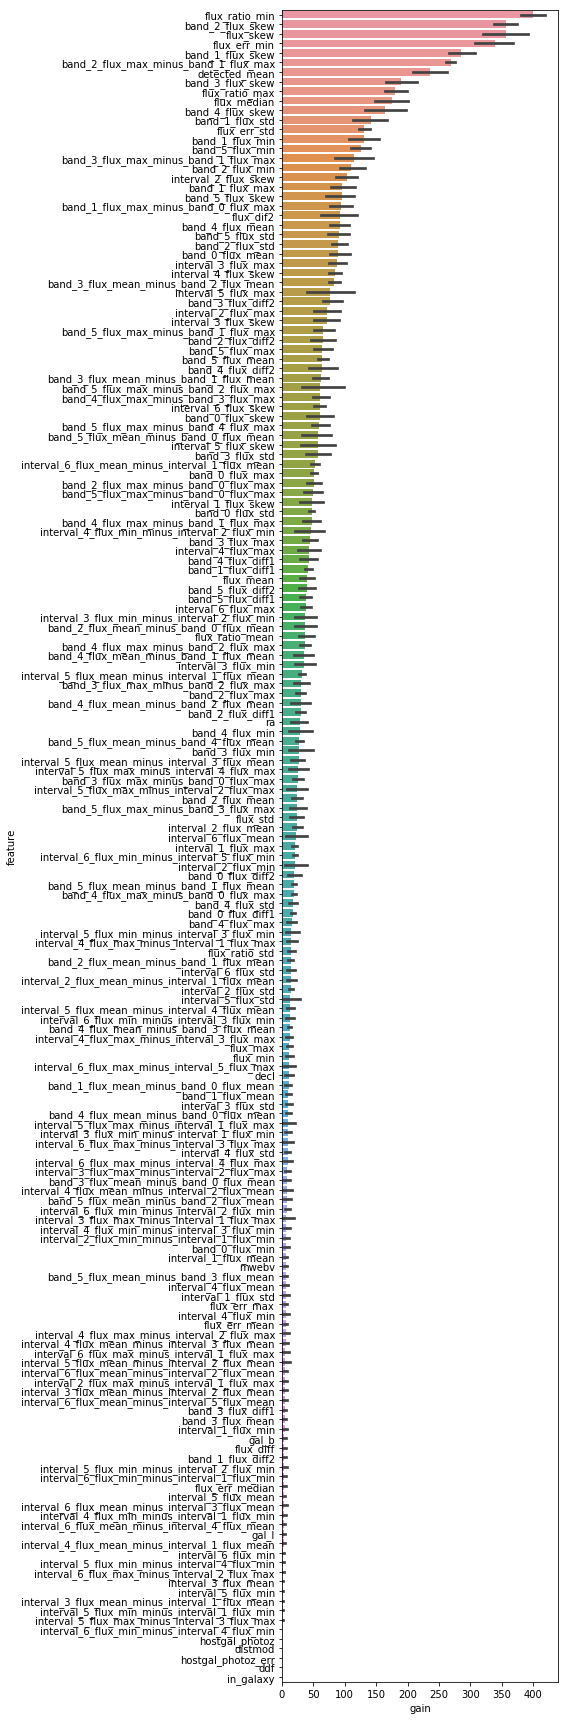

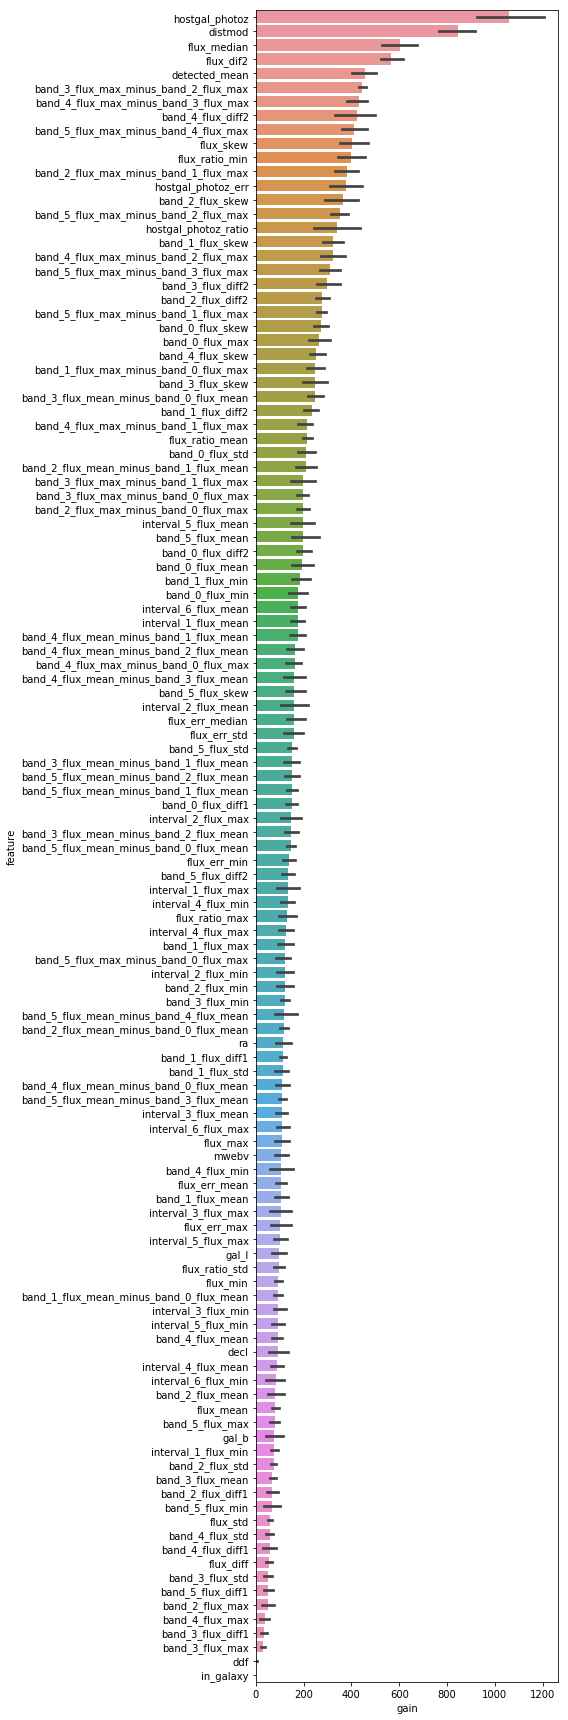

In [12]:
gc.enable()
create_logger()

train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')

full_train_in_gal, full_train_out_gal = fabriquer_feat(train, meta_train)

del train

print('Training begins...')

y_list = []
preds_list = []
clf_list = []
val_score_list = []
for df in [full_train_in_gal, full_train_out_gal]:
    del df['object_id']
    df_mean = df.mean(axis=0)
    df.fillna(df_mean, inplace=True)
    y = df['target']
    y_list.append(y)
    del df['target']
    gc.collect()
    get_logger().info(df.columns)

    clfs, importances, preds, val_score = train_classifiers(df, y)
    save_importances(importances_=importances)
    preds_list.append(preds)
    clf_list.append(clfs)
    val_score_list.append(val_score)

    

    
    
    


print('Let us check the logloss when objects are trained separately...')
# all_y = pd.concat(y_list, ignore_index=True)
all_y = np.concatenate((y_list[0], y_list[1]), axis=0)

preds_in_gal = preds_list[0]
preds_out_gal = preds_list[1]
in_classes = [6, 16, 53, 65, 92]
out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

in_df = set_df(preds_in_gal, in_classes)
out_df = set_df(preds_out_gal, out_classes)
in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)


val_score_tot = multi_weighted_logloss(y_true=all_y, y_preds=in_out_df.values)

print('Separate MULTI WEIGHTED LOG LOSS : %.5f ' % val_score_tot)

val_score_list.append(val_score_tot)

score_tab = pd.DataFrame({'Model':['Galaxy_Model', 'Extragalaxy_Model','Bi_Model'], 'Score':val_score_list})
print(score_tab)
score_tab.to_csv(r'../feat/validation_scores_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

In [14]:
y = all_y.copy()
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
cnf_matrix = confusion_matrix(y_map, np.argmax(in_out_df.values, axis=-1))  
np.set_printoptions(precision=2)

Normalized confusion matrix
[[7.88e-01 0.00e+00 1.99e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.79e-01 0.00e+00 0.00e+00 0.00e+00 1.32e-02 0.00e+00]
 [0.00e+00 6.65e-01 0.00e+00 1.45e-01 0.00e+00 0.00e+00 1.41e-02 2.02e-03
  0.00e+00 2.02e-03 2.02e-03 1.68e-01 0.00e+00 2.02e-03]
 [1.08e-03 0.00e+00 9.92e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  5.41e-03 0.00e+00 0.00e+00 0.00e+00 1.08e-03 0.00e+00]
 [0.00e+00 5.53e-02 0.00e+00 5.57e-01 8.38e-04 0.00e+00 5.70e-02 9.22e-03
  0.00e+00 3.35e-03 0.00e+00 3.10e-01 0.00e+00 6.71e-03]
 [0.00e+00 5.46e-03 0.00e+00 2.68e-01 1.64e-02 0.00e+00 4.92e-02 1.64e-02
  0.00e+00 5.46e-03 0.00e+00 6.34e-01 0.00e+00 5.46e-03]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.00e-01 0.00e+00 0.00e+00
  6.67e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 8.26e-03 0.00e+00 2.77e-01 2.07e-03 0.00e+00 4.28e-01 2.89e-02
  0.00e+00 1.86e-02 0.00e+00 2.29e-01 0.00e+00 8.26e-03]
 [0.00e+00 2.94e-02 0.00e+00 1.37e-01 0.00e+00 0.00e+00

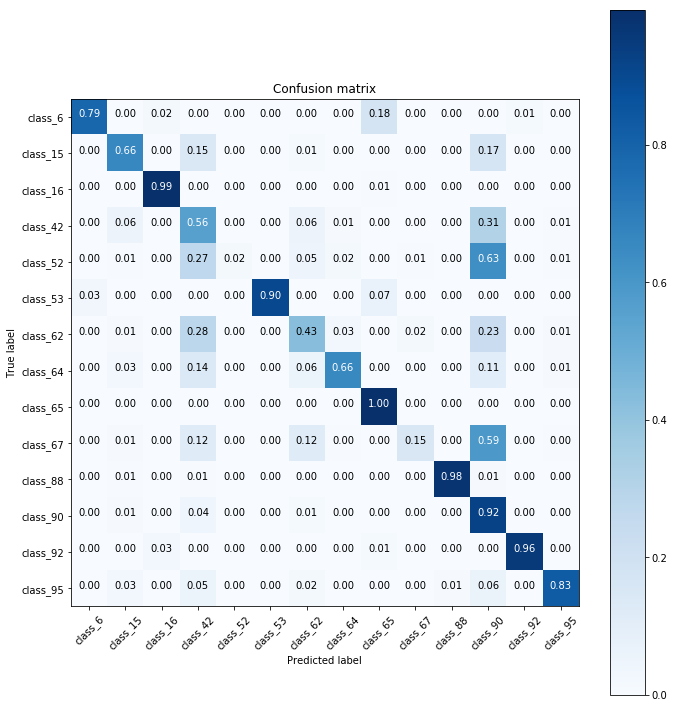

In [18]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')